In [71]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Polygon

In [6]:
n_points = 2000
eps = 1e-3
noise_std = 0.2
h = 0.02

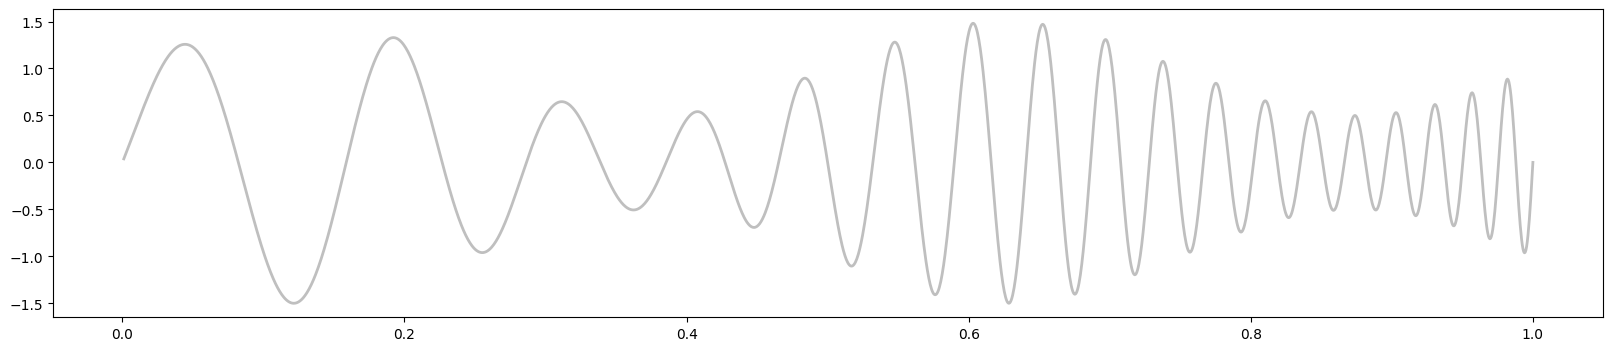

In [7]:
x = np.linspace(eps, 1.0, n_points)
y_clean = (1 + 0.5 * np.sin(4 * np.pi * x)) * np.sin(2 * np.pi * (6 * x + 12 * x**3))

plt.figure(figsize=(20, 4))
plt.plot(x, y_clean, color='gray', linewidth=2, alpha=0.5)
plt.show()

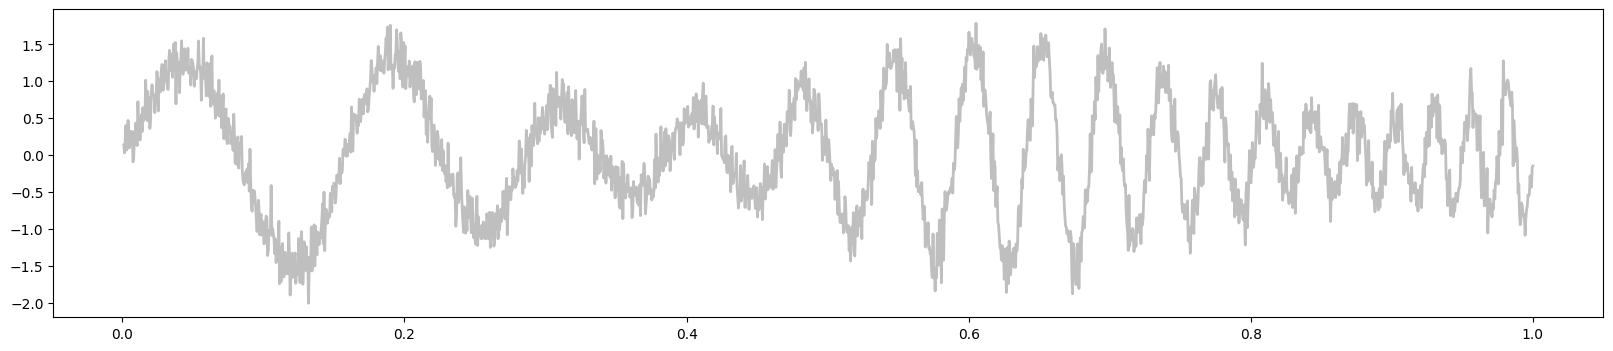

In [8]:
np.random.seed(42)
noise = np.random.normal(scale=noise_std, size=n_points)
y_noisy = y_clean + noise

plt.figure(figsize=(20, 4))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.show()

In [87]:
h_start = 0.1
a = np.sqrt(2)
h_min = 0.02

components = []
current_residuals = y_noisy.copy()
h_curr = h_start

count = 0
while h_curr >= h_min:
    count += 1
    print("Step", count, "| h =", round(h_curr, 4))
    n = len(x)
    y_smooth = np.zeros(n)
    
    for i in range(n):
        t = x[i]
        
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]            # Rolling Window
        local_res = current_residuals[indices]
            
        u = (x[indices] - t) / h_curr                                           # s - t / h
        weights = 0.75 * (1 - u**2)                                             # Epanechnikov Kernel
        
        def loss_function(m):
            return np.sum(np.abs(local_res - m) * weights)
        result = minimize_scalar(loss_function)
    
        if result.success:
            y_smooth[i] = result.x
        else:
            y_smooth[i] = np.mean(local_res)
            print("OH NO")
        
    components.append(y_smooth)
    current_residuals = current_residuals - y_smooth
    h_curr = h_curr / a

Step 1 | h = 0.1
Step 2 | h = 0.0707
Step 3 | h = 0.05
Step 4 | h = 0.0354
Step 5 | h = 0.025


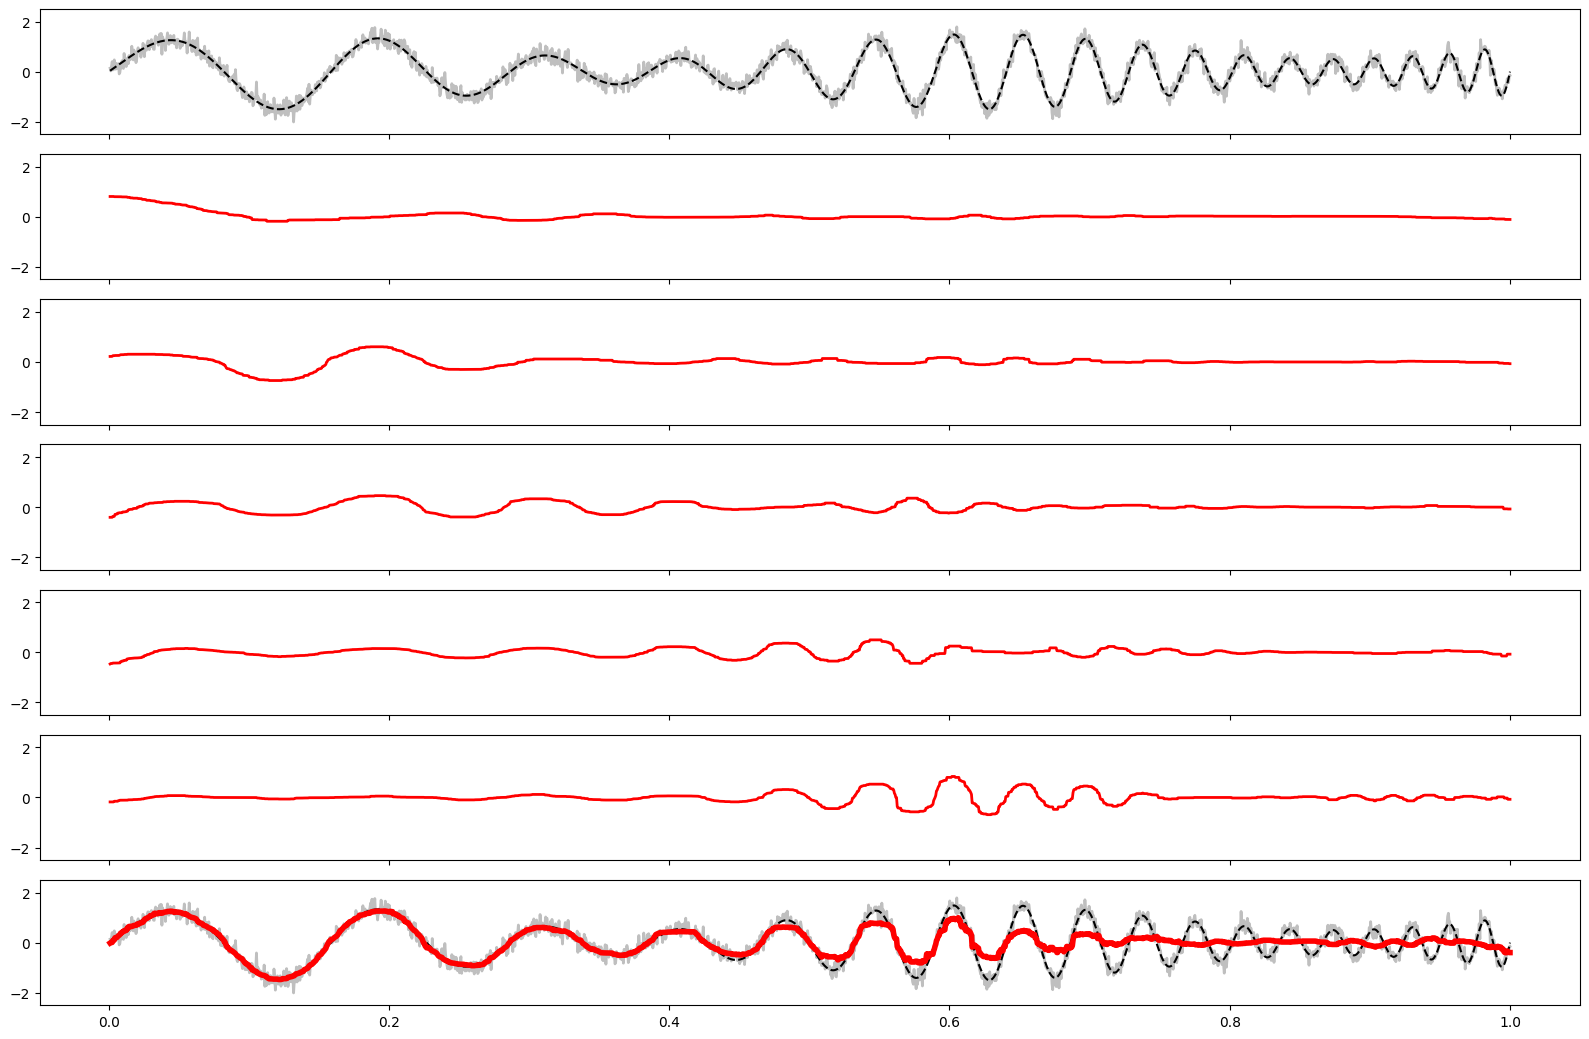

In [95]:
n_comp = len(components)
fig, axes = plt.subplots(n_comp + 2, 1, figsize=(16, 1.5 * (n_comp + 2)), sharex=True)

ax = axes[0]
ax.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
ax.plot(x, y_clean, color='black', linestyle='--', linewidth=1.5)
ax.set_ylim(-2.5, 2.5)

y_reconstructed = np.zeros_like(x)

for i, comp in enumerate(components):
    ax = axes[i+1]
    ax.plot(x, comp, color='red', linewidth=2)
    ax.set_ylim(-2.5, 2.5)

    y_reconstructed += comp

ax = axes[-1]
ax.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
ax.plot(x, y_clean, color='black', linestyle='--', linewidth=1.5)
ax.plot(x, y_reconstructed, color='red', linewidth=4)
ax.set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

開始迭代計算...
Step 1 | h = 0.1000
Step 2 | h = 0.0707
Step 3 | h = 0.0500
Step 4 | h = 0.0354
Step 5 | h = 0.0250


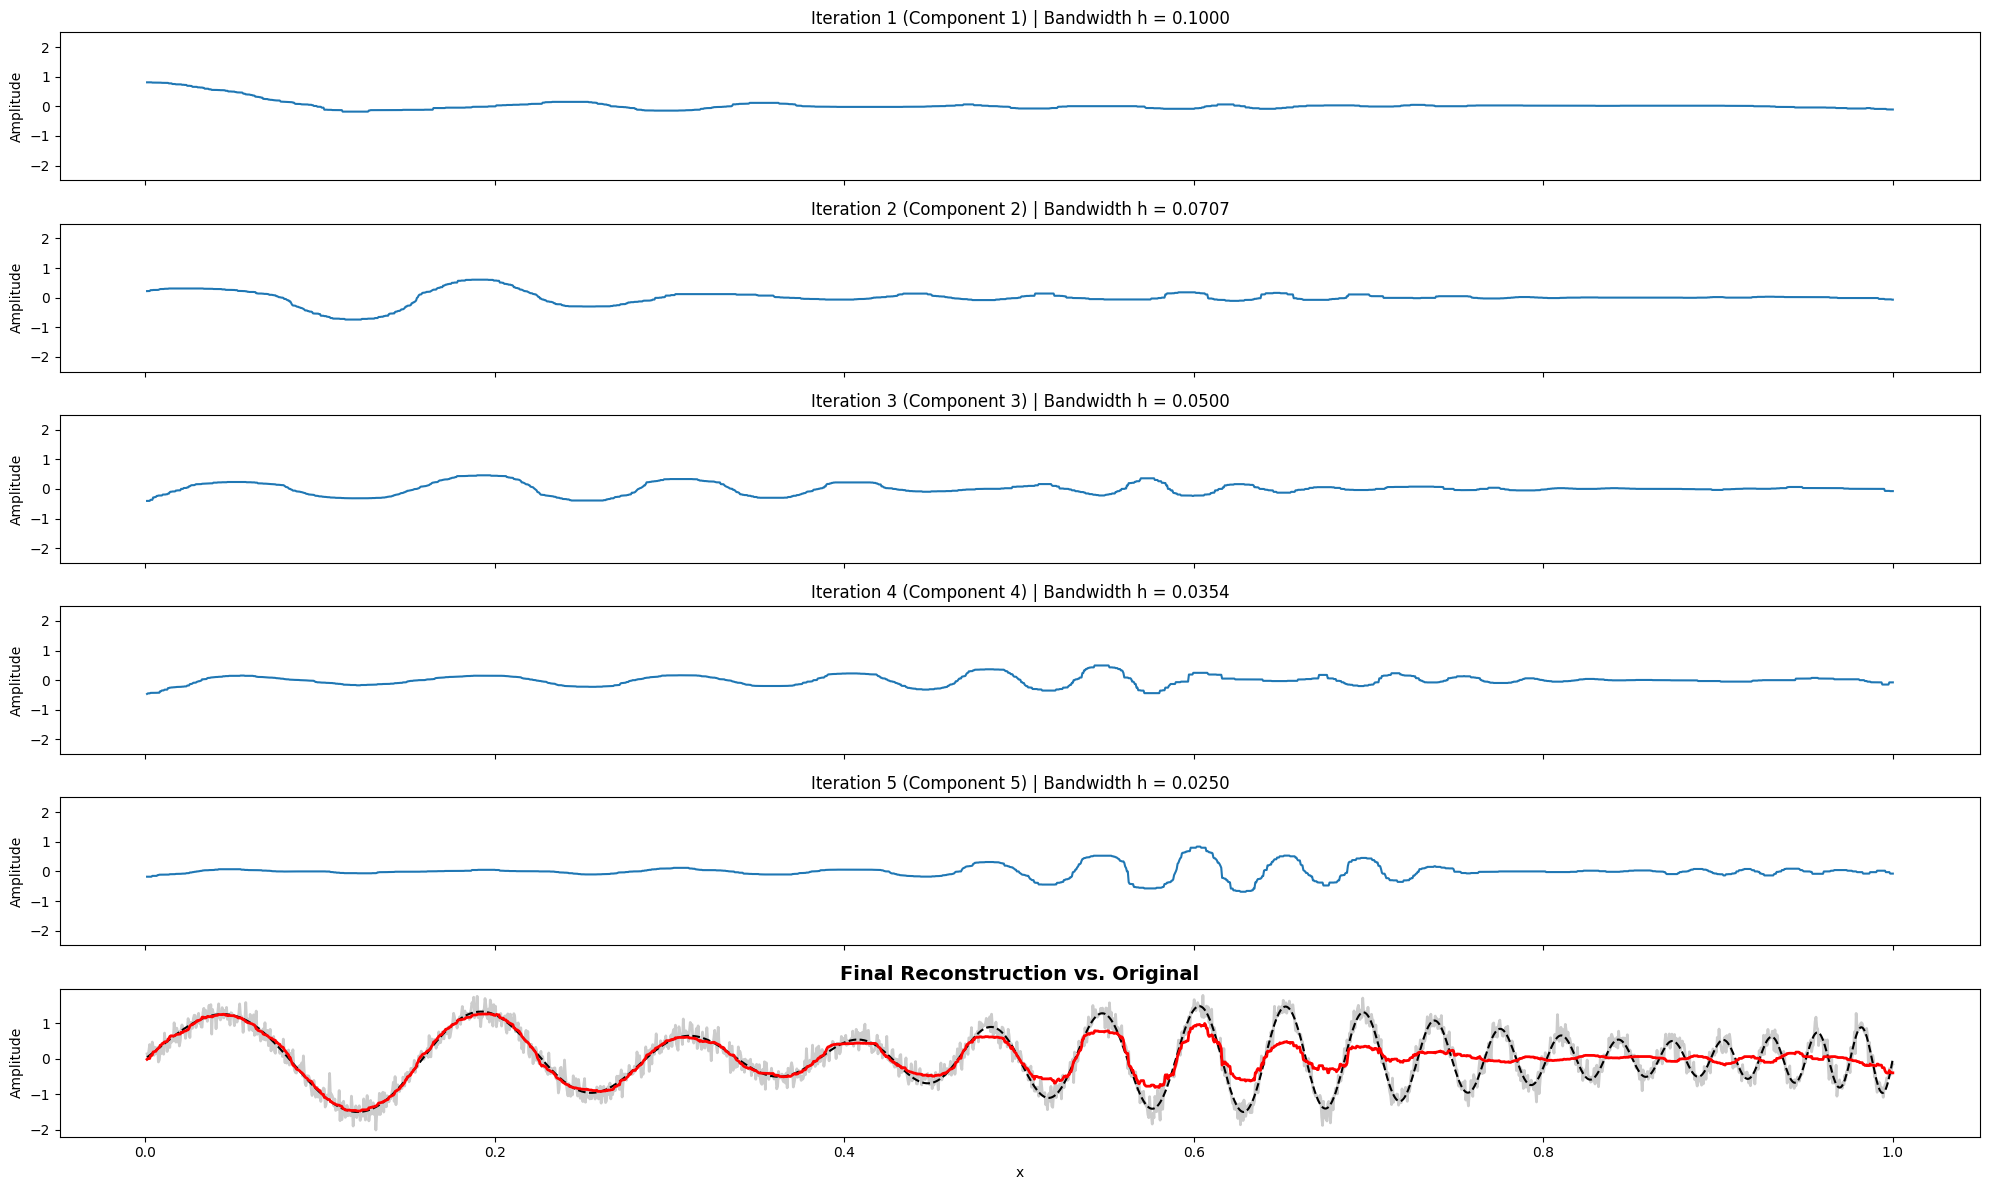

In [53]:
h_start = 0.1
a = np.sqrt(2)
h_min = 0.02

components = []
h_values = []
current_residuals = y_noisy.copy()
h_curr = h_start

count = 0

print("開始迭代計算...")
while h_curr >= h_min:
    count += 1

    h_values.append(h_curr)
    print(f"Step {count} | h = {h_curr:.4f}")
    
    n = len(x)
    y_smooth = np.zeros(n)
    

    for i in range(n):
        t = x[i]
        indices = np.where((x >= t - h_curr) & (x <= t + h_curr))[0]
        if len(indices) == 0:
            y_smooth[i] = 0.0
            continue
            
        u = (x[indices] - t) / h_curr
        weights = 0.75 * (1 - u**2)
        
        local_res = current_residuals[indices]
        
        sorter = np.argsort(local_res)
        sorted_values = local_res[sorter]
        sorted_weights = weights[sorter]
        
        cumulative_weight = np.cumsum(sorted_weights)
        total_weight = cumulative_weight[-1]
        
        median_idx = np.searchsorted(cumulative_weight, total_weight / 2.0)
        median_idx = min(median_idx, len(sorted_values) - 1)
        
        y_smooth[i] = sorted_values[median_idx]
        
    components.append(y_smooth)
    current_residuals = current_residuals - y_smooth
    h_curr = h_curr / a


y_reconstructed = np.zeros_like(x)
for comp in components:
    y_reconstructed += comp


num_iterations = len(components)

fig, axes = plt.subplots(num_iterations + 1, 1, figsize=(20, 2 * (num_iterations + 1)), sharex=True)


if num_iterations + 1 == 1:
    axes = [axes]


for i, ax in enumerate(axes[:-1]):
    ax.plot(x, components[i], color='tab:blue', linewidth=1.5)
    ax.set_title(f"Iteration {i+1} (Component {i+1}) | Bandwidth h = {h_values[i]:.4f}", fontsize=12)
    ax.set_ylabel("Amplitude")
    ax.set_ylim(-2.5, 2.5)


ax_final = axes[-1]
ax_final.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.4, label='Noisy Input')
ax_final.plot(x, y_clean, color='black', linestyle='--', linewidth=1.5, label='Ground Truth (Clean)')
ax_final.plot(x, y_reconstructed, color='red', linewidth=2, label='Reconstructed Signal')
ax_final.set_title("Final Reconstruction vs. Original", fontsize=14, fontweight='bold')
ax_final.set_xlabel("x")
ax_final.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

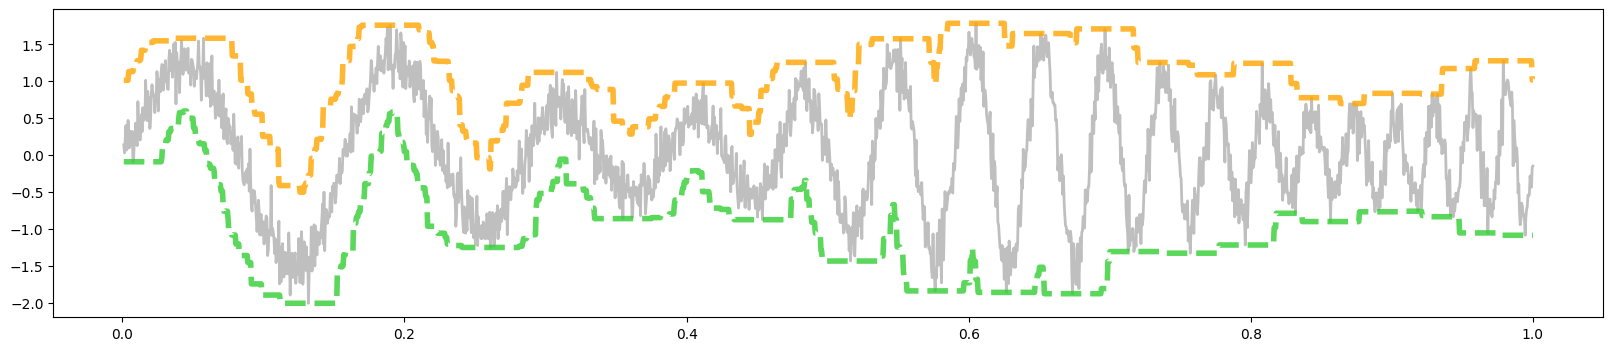

In [20]:
dx = x[1] - x[0]
window_points = int(round(h / dx)) * 2 + 1
window_points = max(window_points, 1)  # safety

y_series = pd.Series(y_noisy)
y_max = y_series.rolling(window=window_points, center=True).max().to_numpy()
y_min = y_series.rolling(window=window_points, center=True).min().to_numpy()

y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

plt.figure(figsize=(20, 4))
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.plot(x, y_max, color='orange', linewidth=4, linestyle='--', alpha=0.8)
plt.plot(x, y_min, color='limegreen', linewidth=4, linestyle='--', alpha=0.8)
plt.show()

In [16]:
envelope = 0.5 * (y_max + y_min)      # (max + min)/2
IMF1 = y_noisy - envelope             # first IMF-like component
residual = envelope                   # residual after removing IMF1

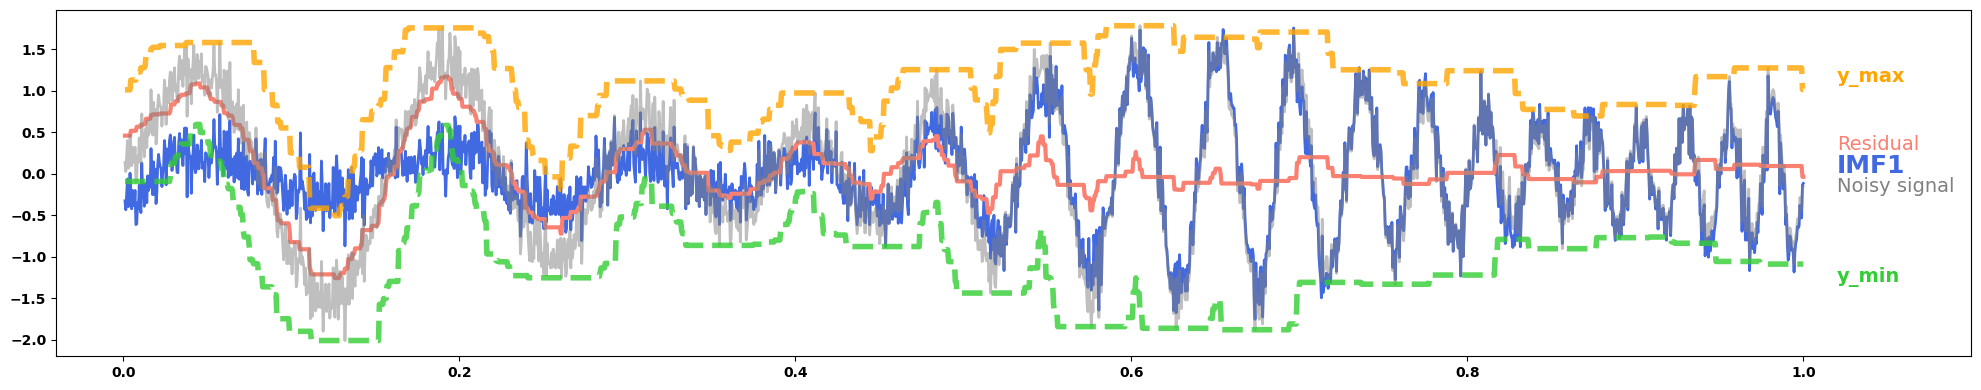

In [23]:
plt.figure(figsize=(20, 4))
ax = plt.gca()


plt.plot(x, IMF1, label="IMF1 = noisy - envelope", color='royalblue', linewidth=2, alpha=1.0)
plt.plot(x, residual, label="Residual (envelope)", color='salmon', linewidth=3, alpha=1.0)
plt.plot(x, y_noisy, color='gray', linewidth=2, alpha=0.5)
plt.plot(x, y_max, color='orange', linewidth=4, linestyle='--', alpha=0.8)
plt.plot(x, y_min, color='limegreen', linewidth=4, linestyle='--', alpha=0.8)

x_end = x[np.isfinite(x)][-1]
dx = 0.02 * (x_end - x[np.isfinite(x)][0])

labels = []

m = np.isfinite(x) & np.isfinite(y_noisy)
labels.append(dict(y=float(y_noisy[m][-1]), text="Noisy signal", color="gray", fontsize=14, fontweight=None))
m = np.isfinite(x) & np.isfinite(IMF1)
labels.append(dict(y=float(IMF1[m][-1]), text="IMF1", color="royalblue", fontsize=18, fontweight="bold"))
m = np.isfinite(x) & np.isfinite(residual)
labels.append(dict(y=float(residual[m][-1]), text="Residual", color="salmon", fontsize=14, fontweight=None))
m = np.isfinite(x) & np.isfinite(y_max)
labels.append(dict(y=float(y_max[m][-1] + 0.15), text="y_max", color="orange", fontsize=14, fontweight="bold"))
m = np.isfinite(x) & np.isfinite(y_min)
labels.append(dict(y=float(y_min[m][-1] - 0.15), text="y_min", color="limegreen", fontsize=14, fontweight="bold"))


labels = sorted(labels, key=lambda d: d["y"])

y0, y1 = ax.get_ylim()
min_sep = 0.06 * (y1 - y0)

adj_y = []
for d in labels:
    if not adj_y:
        adj_y.append(d["y"])
    else:
        adj_y.append(max(d["y"], adj_y[-1] + min_sep))

shift = 0.0
if adj_y and adj_y[-1] > y1:
    shift = adj_y[-1] - y1
    adj_y = [yy - shift for yy in adj_y]

x_text = x[np.isfinite(x)][-1] + dx
for d, yy in zip(labels, adj_y):
    ax.text(x_text, yy, d["text"], color=d["color"], fontsize=d["fontsize"], fontweight=d["fontweight"] if d["fontweight"] is not None else "normal", va="center")


plt.xlim(-0.04, 1.10)
# plt.ylim(-1.8, 1.8)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("EMD.png", dpi=144, transparent=True)
plt.show()


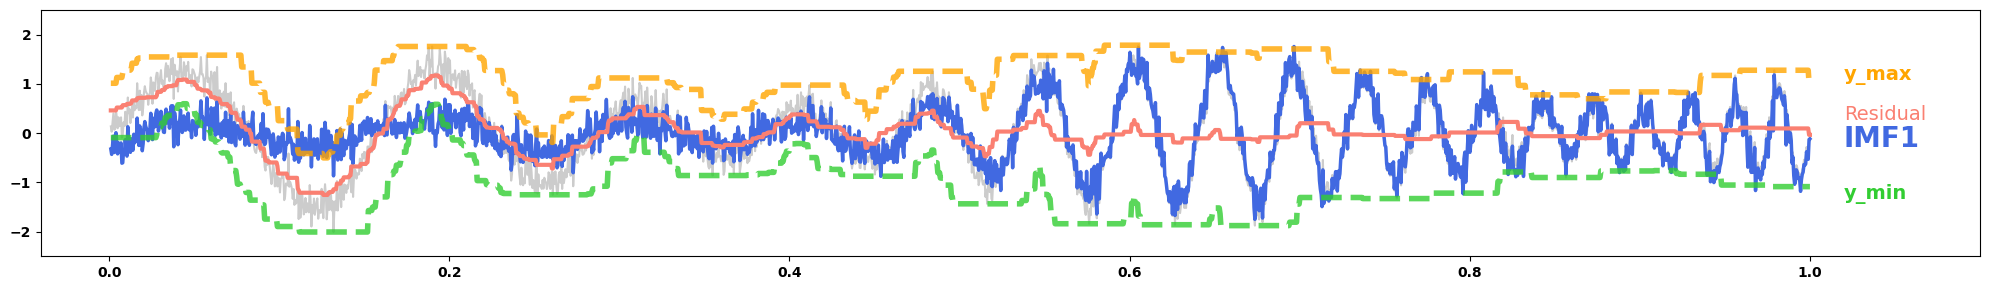

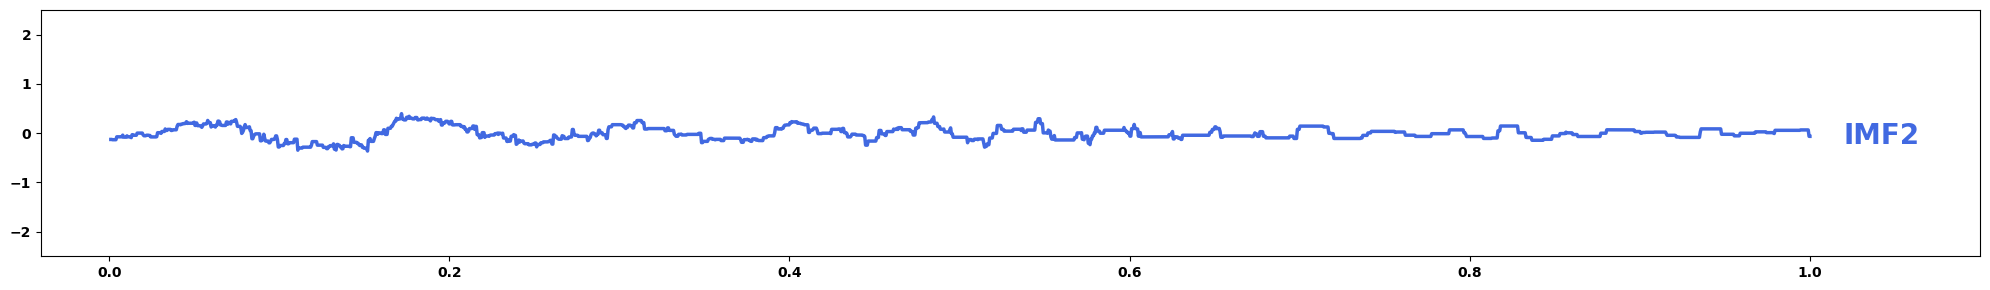

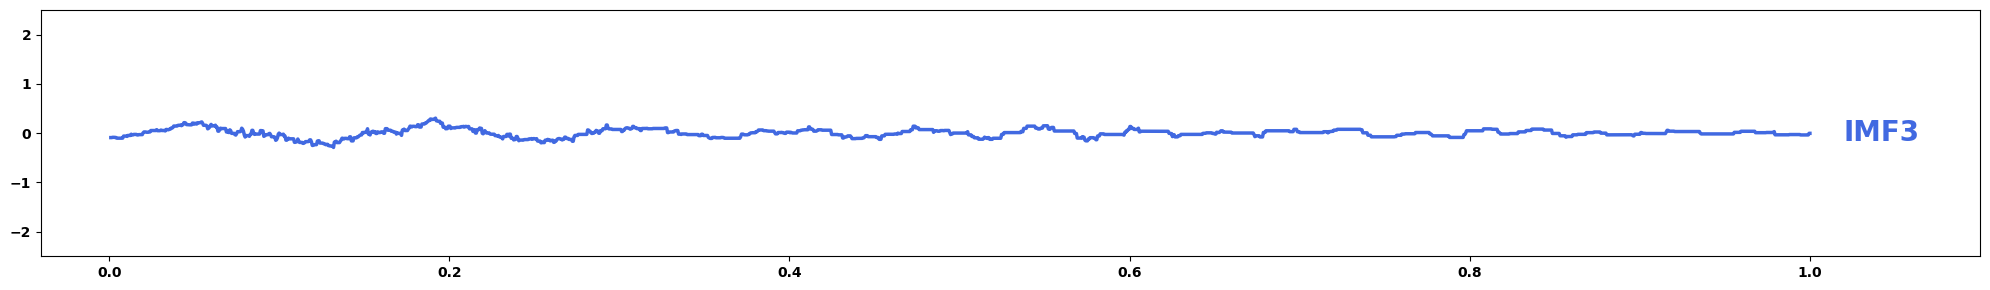

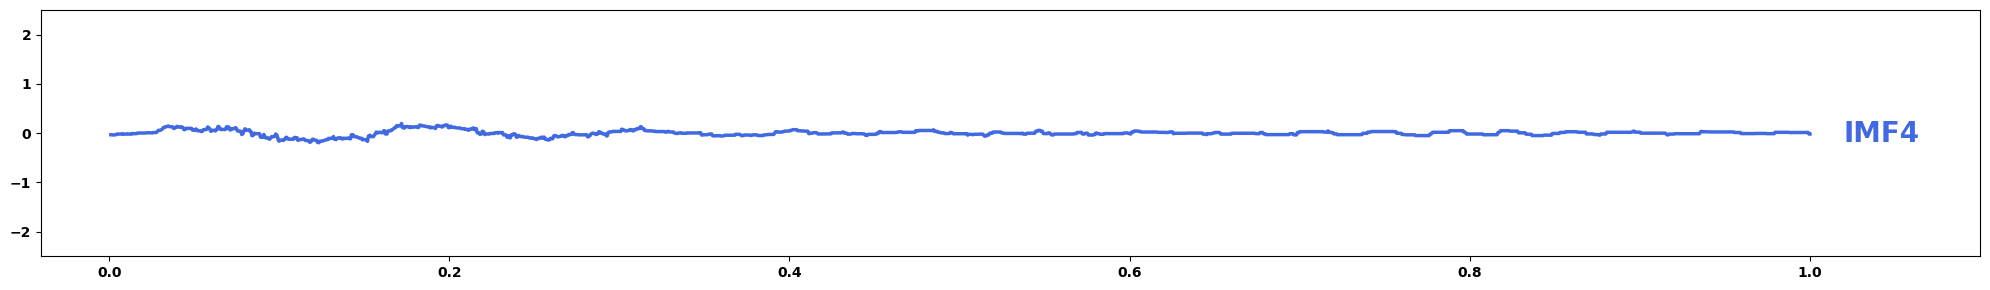

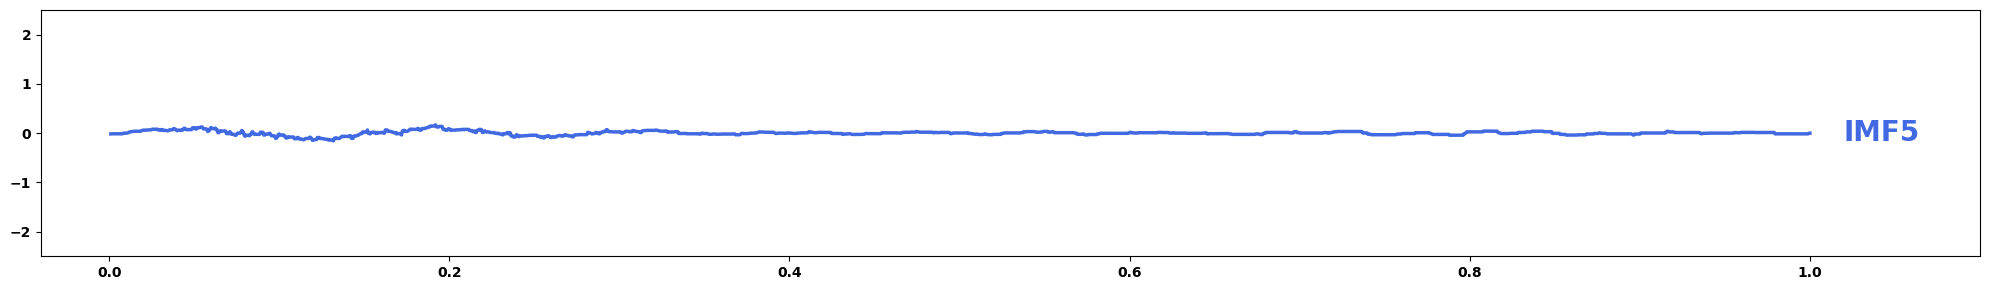

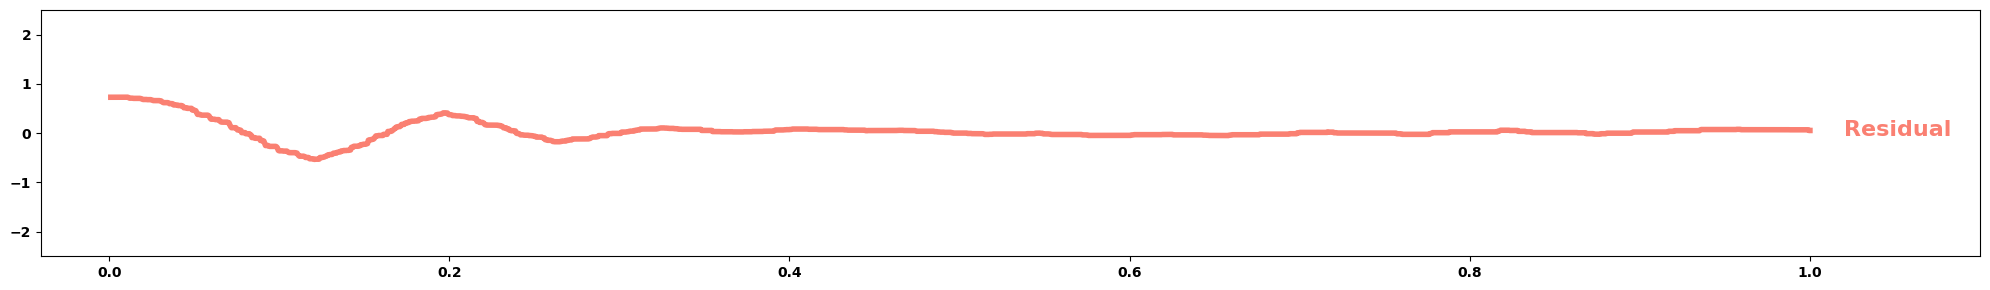

In [37]:
y_current = y_noisy.copy()

for k in range(1, 6):

    y_series = pd.Series(y_current)
    y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
    y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

    envelope = 0.5 * (y_max + y_min)
    IMFk = y_current - envelope
    residual = envelope

    plt.figure(figsize=(20, 3))
    ax = plt.gca()

    if k == 1:
        plt.plot(x, y_current, color='gray', alpha=0.4)
        plt.plot(x, IMFk, color='royalblue', linewidth=2.5)
        plt.plot(x, residual, color='salmon', linewidth=3)
        plt.plot(x, y_max, color='orange', linewidth=4, linestyle='--', alpha=0.8)
        plt.plot(x, y_min, color='limegreen', linewidth=4, linestyle='--', alpha=0.8)
    else:
        plt.plot(x, IMFk, color='royalblue', linewidth=2.5)

    x_end = x[np.isfinite(x)][-1]
    dx_txt = 0.02 * (x_end - x[np.isfinite(x)][0])

    if k == 1:
        labels = []

        m = np.isfinite(x) & np.isfinite(IMFk)
        labels.append(dict(y=float(IMFk[m][-1]), text=f"IMF{k}", color="royalblue", fontsize=20, fontweight='heavy'))

        m = np.isfinite(x) & np.isfinite(residual)
        labels.append(dict(y=float(residual[m][-1]), text="Residual", color="salmon", fontsize=14, fontweight=None))

        m = np.isfinite(x) & np.isfinite(y_max)
        labels.append(dict(y=float(y_max[m][-1] + 0.15), text="y_max", color="orange", fontsize=14, fontweight='bold'))

        m = np.isfinite(x) & np.isfinite(y_min)
        labels.append(dict(y=float(y_min[m][-1] - 0.15), text="y_min", color="limegreen", fontsize=14, fontweight='bold'))

        labels = sorted(labels, key=lambda d: d["y"])

        y0, y1 = ax.get_ylim()
        min_sep = 0.12 * (y1 - y0)

        adj_y = []
        for d in labels:
            if not adj_y:
                adj_y.append(d["y"])
            else:
                adj_y.append(max(d["y"], adj_y[-1] + min_sep))

        shift = 0.0
        if adj_y and adj_y[-1] > y1:
            shift = adj_y[-1] - y1
            adj_y = [yy - shift for yy in adj_y]

        x_text = x[np.isfinite(x)][-1] + dx_txt
        for d, yy in zip(labels, adj_y):
            ax.text(x_text, yy, d["text"], color=d["color"], fontsize=d["fontsize"], fontweight=d["fontweight"] if d["fontweight"] is not None else "normal", va="center")

    else:
        m = np.isfinite(x) & np.isfinite(IMFk)
        ax.text(x[m][-1] + dx_txt, IMFk[m][-1], f"IMF{k}", color="royalblue", fontsize=20, fontweight='heavy', va="center")

    plt.xlim(-0.04, 1.10)
    plt.ylim(-2.5, 2.5)
    plt.xticks(fontsize=10, fontweight='bold')
    plt.yticks(fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"EMD_iter_{k}.png", dpi=144, transparent=True)
    plt.show()

    y_current = residual.copy()

plt.figure(figsize=(20, 3))
ax = plt.gca()
plt.plot(x, y_current, color='salmon', linewidth=4)

x_end = x[np.isfinite(x)][-1]
dx_txt = 0.02 * (x_end - x[np.isfinite(x)][0])

m = np.isfinite(x) & np.isfinite(y_current)
ax.text(x[m][-1] + dx_txt, y_current[m][-1], "Residual", color="salmon", fontsize=16, fontweight='heavy', va="center")

plt.xlim(-0.04, 1.10)
plt.ylim(-2.5, 2.5)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig("EMD_final_residual.png", dpi=144, transparent=True)
plt.show()

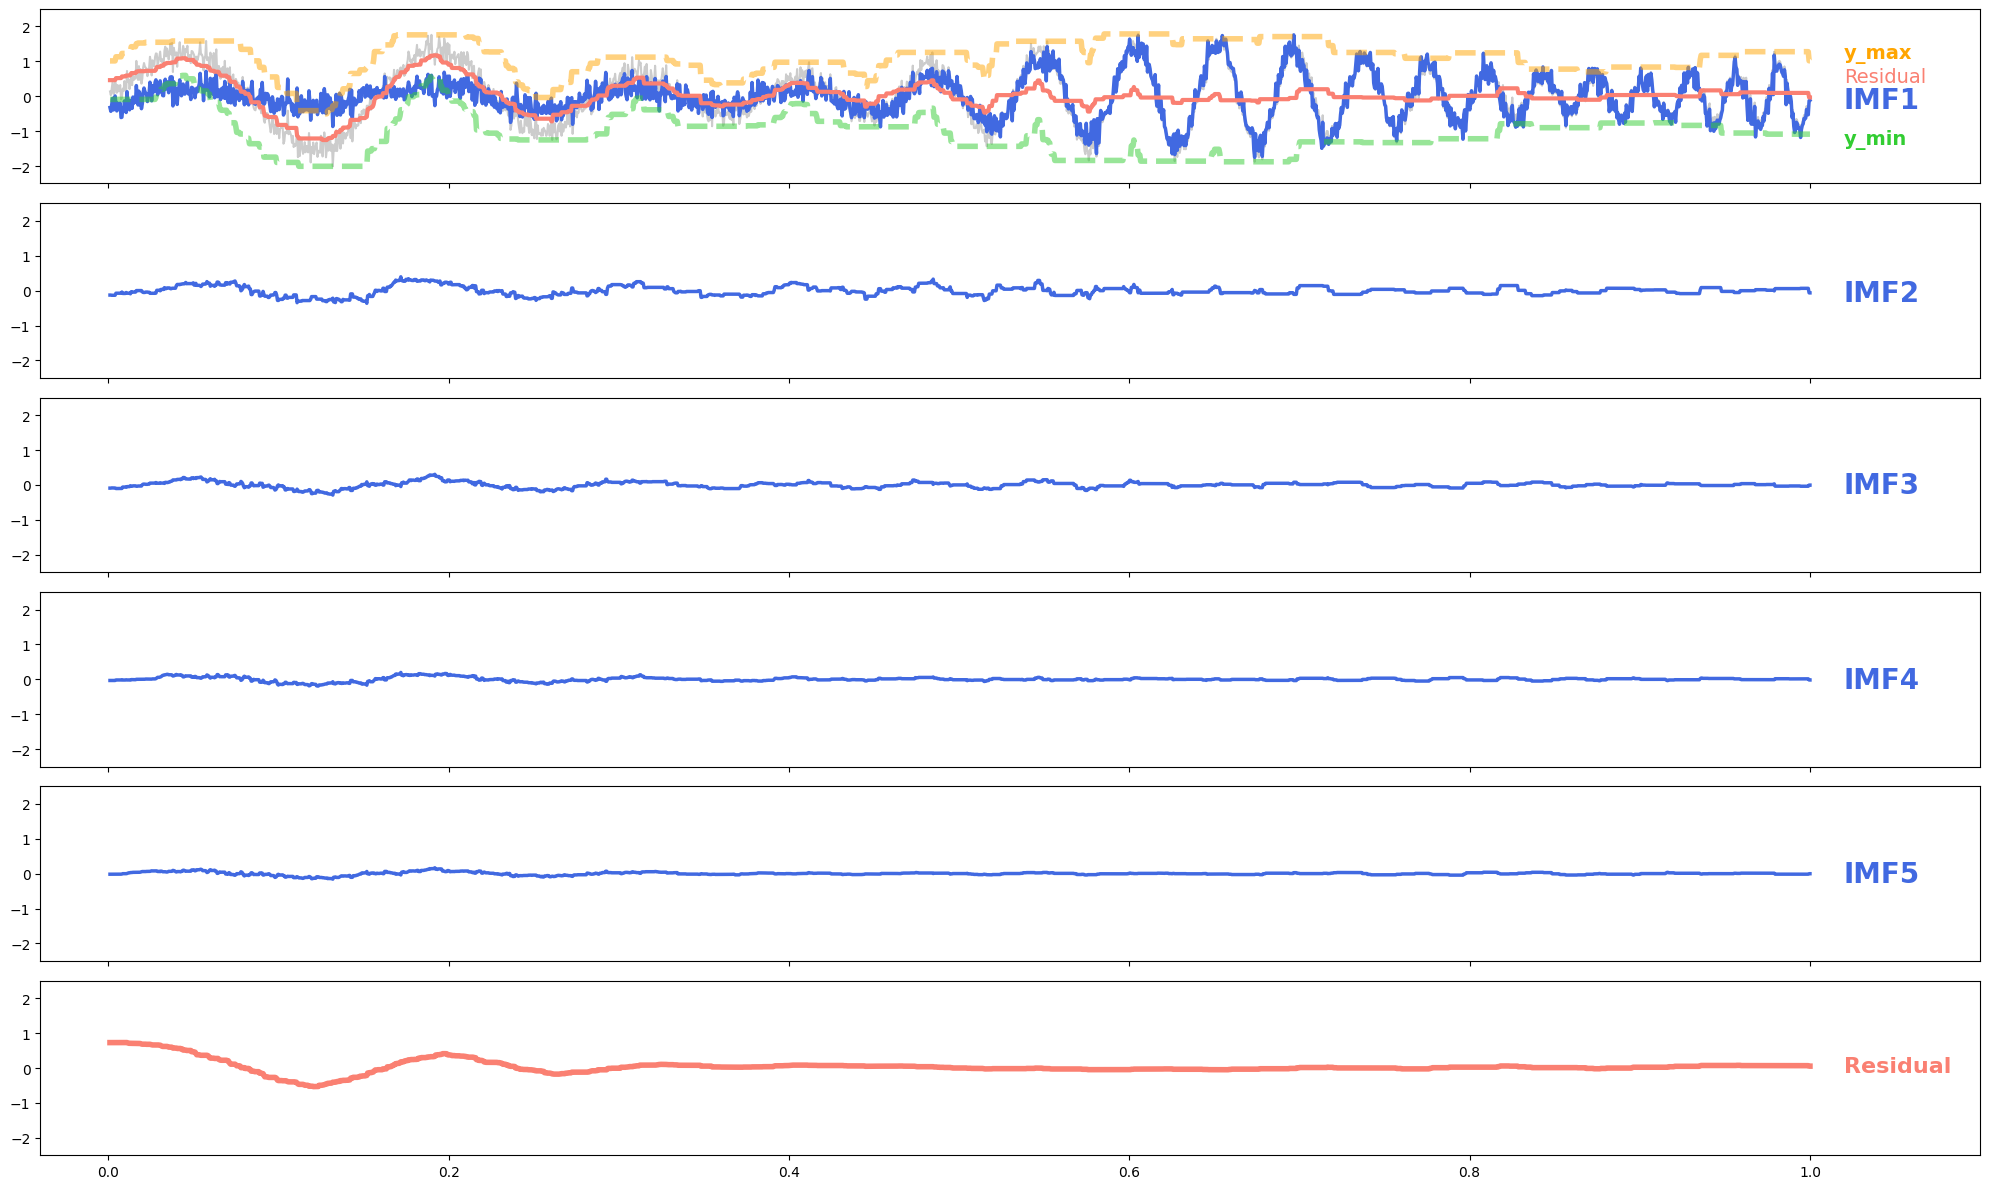

In [39]:
fig, axes = plt.subplots(6, 1, figsize=(20, 12), sharex=True)

y_current = y_noisy.copy()

for k in range(1, 6):

    ax = axes[k-1]

    y_series = pd.Series(y_current)
    y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
    y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

    envelope = 0.5 * (y_max + y_min)
    IMFk = y_current - envelope
    residual = envelope

    if k == 1:
        ax.plot(x, y_current, color='gray', alpha=0.4)
        ax.plot(x, IMFk, color='royalblue', linewidth=2.5)
        ax.plot(x, residual, color='salmon', linewidth=3)
        ax.plot(x, y_max, color='orange', linewidth=4, linestyle='--', alpha=0.5)
        ax.plot(x, y_min, color='limegreen', linewidth=4, linestyle='--', alpha=0.5)
    else:
        ax.plot(x, IMFk, color='royalblue', linewidth=2.5)

    x_end = x[np.isfinite(x)][-1]
    dx_txt = 0.02 * (x_end - x[np.isfinite(x)][0])

    if k == 1:
        labels = []

        m = np.isfinite(x) & np.isfinite(IMFk)
        labels.append(dict(y=float(IMFk[m][-1]), text=f"IMF{k}", color="royalblue", fontsize=20, fontweight='heavy'))

        m = np.isfinite(x) & np.isfinite(residual)
        labels.append(dict(y=float(residual[m][-1]), text="Residual", color="salmon", fontsize=14, fontweight=None))

        m = np.isfinite(x) & np.isfinite(y_max)
        labels.append(dict(y=float(y_max[m][-1] + 0.15), text="y_max", color="orange", fontsize=14, fontweight='bold'))

        m = np.isfinite(x) & np.isfinite(y_min)
        labels.append(dict(y=float(y_min[m][-1] - 0.15), text="y_min", color="limegreen", fontsize=14, fontweight='bold'))

        labels = sorted(labels, key=lambda d: d["y"])

        y0, y1 = ax.get_ylim()
        min_sep = 0.16 * (y1 - y0)

        adj_y = []
        for d in labels:
            if not adj_y:
                adj_y.append(d["y"])
            else:
                adj_y.append(max(d["y"], adj_y[-1] + min_sep))

        shift = 0.0
        if adj_y and adj_y[-1] > y1:
            shift = adj_y[-1] - y1
            adj_y = [yy - shift for yy in adj_y]

        x_text = x[np.isfinite(x)][-1] + dx_txt
        for d, yy in zip(labels, adj_y):
            ax.text(x_text, yy, d["text"], color=d["color"], fontsize=d["fontsize"], fontweight=d["fontweight"] if d["fontweight"] is not None else "normal", va="center")

    else:
        m = np.isfinite(x) & np.isfinite(IMFk)
        ax.text(x[m][-1] + dx_txt, IMFk[m][-1], f"IMF{k}", color="royalblue", fontsize=20, fontweight='heavy', va="center")

    ax.set_xlim(-0.04, 1.10)
    ax.set_ylim(-2.5, 2.5)
    ax.tick_params(labelsize=10)

    y_current = residual.copy()

ax = axes[5]
ax.plot(x, y_current, color='salmon', linewidth=4)

x_end = x[np.isfinite(x)][-1]
dx_txt = 0.02 * (x_end - x[np.isfinite(x)][0])

m = np.isfinite(x) & np.isfinite(y_current)
ax.text(x[m][-1] + dx_txt, y_current[m][-1], "Residual", color="salmon", fontsize=16, fontweight='heavy', va="center")

ax.set_xlim(-0.04, 1.10)
ax.set_ylim(-2.5, 2.5)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("EMD_Full.png", dpi=144, transparent=True)
plt.show()

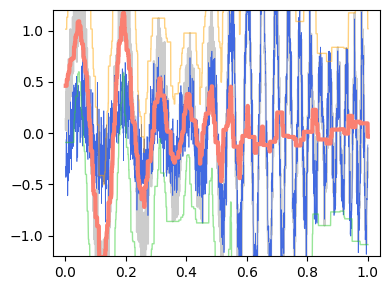

In [42]:
y_current = y_noisy.copy()

for k in range(1, 2):

    y_series = pd.Series(y_current)
    y_max = y_series.rolling(window=window_points, center=True, min_periods=1).max().to_numpy()
    y_min = y_series.rolling(window=window_points, center=True, min_periods=1).min().to_numpy()

    envelope = 0.5 * (y_max + y_min)
    IMFk = y_current - envelope
    residual = envelope

    plt.figure(figsize=(4, 3))

    plt.plot(x, y_current, color='gray', alpha=0.4)
    plt.plot(x, IMFk, color='royalblue', linewidth=0.5)
    plt.plot(x, residual, color='salmon', linewidth=3)
    plt.plot(x, y_max, color='orange', linewidth=1, alpha=0.5)
    plt.plot(x, y_min, color='limegreen', linewidth=1, alpha=0.5)

    plt.xlim(-0.04, 1.04)
    plt.ylim(-1.2, 1.2)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(f"EMD_Slides_Logo.png", dpi=144, transparent=True)
    plt.show()

    y_current = residual.copy()